# Requirements

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pmdarima import auto_arima

In [3]:
!pip install fedot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from fedot.core.data.multi_modal import MultiModalData
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from scipy.ndimage import gaussian_filter1d
from scipy import signal
from statsmodels.tsa.ar_model import AutoReg


from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from numpy.linalg import LinAlgError

warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 12.0
pd.set_option('display.max_columns', None)

# Preprocessing

In [9]:
df = pd.read_csv('Turbine_Data.csv')#, index_col=0)
df.head()

FileNotFoundError: ignored

In [8]:
# df = pd.read_csv('Turbine_Data.csv')#, index_col=0)
df.drop(inplace=True, columns=['Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle', 'WTG'])
df = df.dropna(axis=0)
df.info()

NameError: ignored

In [ ]:
df.to_csv('/content/Turbine_Data45.csv', index=False)

In [ ]:
df.head()

In [ ]:
df2 = pd.read_csv('Turbine_Data45.csv')#, index_col=0)
df2.head()

# Preprocessig with new dataset

In [6]:
df = pd.read_csv('Turbine_Data45.csv')

In [7]:
df = df.rename(columns={'Unnamed: 0': 'Date'})
df1 = df.iloc[30000:31400]

In [151]:
df1.head()

,Date,ActivePower,AmbientTemperatue,BearingShaftTemperature,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
30000,2019-11-25 18:20:00+00:00,484.811382,23.135894,42.864679,0.0,67.471107,58.901955,1160.744512,71.059386,70.245864,32.995312,34.187500,173.50,99.035418,10.401707,2.0,173.50,5.848312
30001,2019-11-25 18:30:00+00:00,473.886145,23.044191,42.589469,0.0,67.089858,58.866143,1164.178744,69.943800,69.073047,32.990576,34.141677,175.75,97.104932,10.434384,2.0,175.75,5.926594
30002,2019-11-25 18:40:00+00:00,410.817685,22.896918,42.283699,0.0,66.203717,58.518284,1099.922987,68.671986,67.786732,32.977397,34.066667,169.00,83.383613,9.859029,2.0,169.00,5.654822
30003,2019-11-25 18:50:00+00:00,425.636621,22.825172,42.087679,0.0,65.966496,58.311730,1121.525905,67.879549,66.982792,32.890854,33.996761,169.00,86.624567,10.057160,2.0,169.00,5.743376
30004,2019-11-25 19:00:00+00:00,403.702268,22.820358,41.909716,0.0,65.871333,58.187267,1102.214295,67.240854,66.354474,32.233649,33.890022,169.00,82.993174,9.886101,2.0,169.00,5.601631


In [152]:
df1.tail()

,Date,ActivePower,AmbientTemperatue,BearingShaftTemperature,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
31395,2019-12-07 13:30:00+00:00,-5.703843,22.659033,28.263172,0.0,41.927086,39.918735,0.0,31.712917,31.522817,26.996611,35.963110,164.200000,-13.592530,0.0,16384.0,164.200000,1.739156
31396,2019-12-07 13:40:00+00:00,-5.776515,22.689633,28.256155,0.0,41.923471,39.911043,0.0,31.647467,31.457150,26.996744,35.937500,148.250000,-13.317937,0.0,16384.0,148.250000,1.645661
31397,2019-12-07 13:50:00+00:00,-5.297811,22.614557,28.254601,0.0,41.930567,39.934951,0.0,31.597211,31.406507,26.994691,35.886324,129.000000,-12.133637,0.0,16384.0,129.000000,1.831605
31398,2019-12-07 14:00:00+00:00,-5.479120,22.690502,28.256586,0.0,41.925585,39.950024,0.0,31.542140,31.352322,26.993717,35.821876,114.000000,-11.476812,0.0,16384.0,114.000000,1.389322
31399,2019-12-07 14:10:00+00:00,-5.562889,22.716520,28.255552,0.0,41.924987,39.945067,0.0,31.491217,31.296345,26.991639,35.762725,103.666667,-12.447525,0.0,16384.0,103.666667,1.379390


<Figure size 864x720 with 0 Axes>

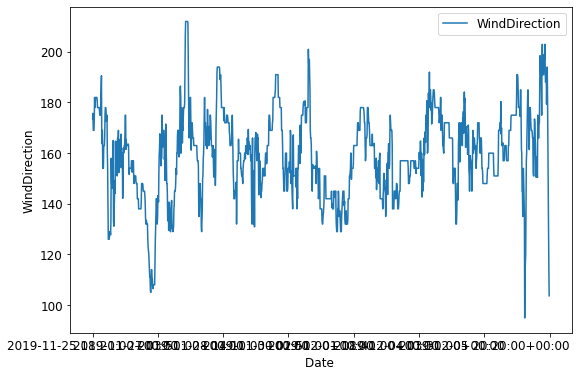

<Figure size 864x720 with 0 Axes>

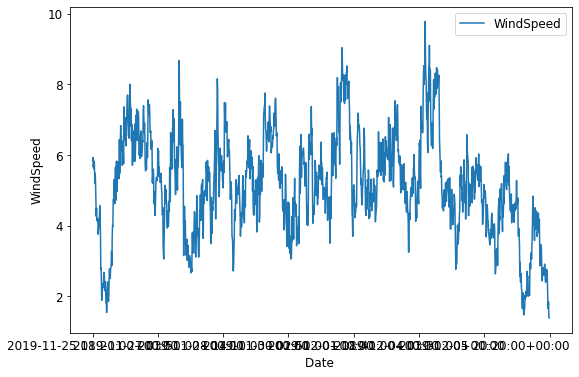

In [8]:
plt.figure(figsize=(12,10))
df1.plot(x = 'Date', y = 'WindDirection', figsize=(9,6))
plt.xlabel(f'Date ' )
plt.ylabel(f'WindDirection')
plt.show()

plt.figure(figsize=(12,10))
df1.plot(x = 'Date', y = 'WindSpeed', figsize=(9,6))
plt.xlabel(f'Date ' )
plt.ylabel(f'WindSpeed')
plt.show()

# Step 1
#### Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).


In [9]:
df

,Date,ActivePower,AmbientTemperatue,BearingShaftTemperature,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-08-19 16:10:00+00:00,1723.840739,27.559161,47.471346,0.0,76.799038,63.229199,1751.589089,111.337475,110.699257,42.003815,40.437500,89.00,0.015372,15.702706,2.0,89.00,15.061125
1,2018-08-19 16:20:00+00:00,1713.430541,27.516543,42.126495,0.0,68.203331,63.155119,1759.218300,111.219889,110.578340,37.336724,35.882182,89.00,0.279944,15.780975,2.0,89.00,11.791917
2,2018-08-19 16:40:00+00:00,1724.986578,27.538246,47.375546,0.0,76.601080,62.995341,1752.282056,110.953116,110.334352,42.003815,40.238596,89.00,-0.225979,15.703549,2.0,89.00,13.433922
3,2018-08-19 17:10:00+00:00,1710.218095,27.454070,47.125813,0.0,76.562569,62.964190,1751.914460,110.820297,110.191098,42.003815,40.000000,95.00,0.523854,15.725234,2.0,95.00,13.016989
4,2018-08-19 17:20:00+00:00,1716.371633,27.404938,41.924676,0.0,67.924564,62.840194,1757.314711,110.730811,110.098841,37.333527,35.506944,94.25,0.607706,15.760685,2.0,94.25,12.377344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,0.0,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.00,13.775785,9.234004,2.0,178.00,3.533445
45715,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,0.0,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.00,8.088928,9.229370,2.0,178.00,3.261231
45716,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,0.0,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.00,4.355978,9.236802,2.0,178.00,3.331839
45717,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,0.0,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.00,12.018077,9.237374,2.0,190.00,3.284468


In [10]:
# df = df.rename(columns={'William%R': 'William'})

In [11]:
df = df1

In [12]:
df = df.convert_dtypes()

datetimes = pd.to_datetime(df["Date"])
df["Date"] = datetimes

target_columns = ['WindDirection', 'WindSpeed']
predict_columns = ['ActivePower', 'RotorRPM', 'AmbientTemperatue', 'ReactivePower']
target_df = df[['Date']+target_columns+predict_columns]
target_df

,Date,WindDirection,WindSpeed,ActivePower,RotorRPM,AmbientTemperatue,ReactivePower
30000,2019-11-25 18:20:00+00:00,173.5,5.848312,484.811382,10.401707,23.135894,99.035418
30001,2019-11-25 18:30:00+00:00,175.75,5.926594,473.886145,10.434384,23.044191,97.104932
30002,2019-11-25 18:40:00+00:00,169.0,5.654822,410.817685,9.859029,22.896918,83.383613
30003,2019-11-25 18:50:00+00:00,169.0,5.743376,425.636621,10.05716,22.825172,86.624567
30004,2019-11-25 19:00:00+00:00,169.0,5.601631,403.702268,9.886101,22.820358,82.993174
...,...,...,...,...,...,...,...
31395,2019-12-07 13:30:00+00:00,164.2,1.739156,-5.703843,0.0,22.659033,-13.59253
31396,2019-12-07 13:40:00+00:00,148.25,1.645661,-5.776515,0.0,22.689633,-13.317937
31397,2019-12-07 13:50:00+00:00,129.0,1.831605,-5.297811,0.0,22.614557,-12.133637
31398,2019-12-07 14:00:00+00:00,114.0,1.389322,-5.47912,0.0,22.690502,-11.476812


<Figure size 864x720 with 0 Axes>

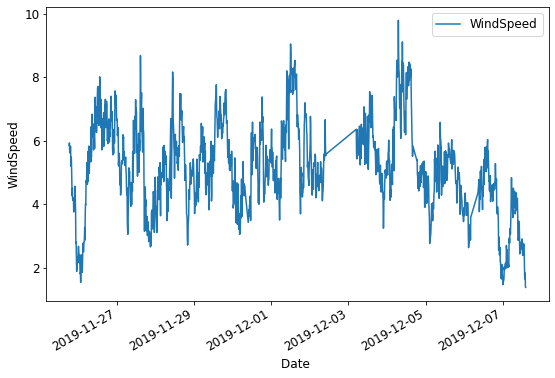

<Figure size 864x720 with 0 Axes>

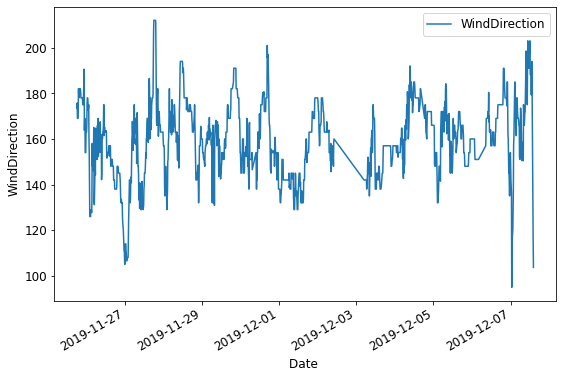

In [13]:
plt.figure(figsize=(12,10))
target_df.plot(x = 'Date', y = 'WindSpeed', figsize=(9,6))
plt.xlabel(f'Date ' )
plt.ylabel(f'WindSpeed')
plt.show()

plt.figure(figsize=(12,10))
target_df.plot(x = 'Date', y = 'WindDirection', figsize=(9,6))
plt.xlabel(f'Date ' )
plt.ylabel(f'WindDirection')
plt.show()

# Step 2 
#### Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.



In [14]:
import statsmodels.tsa.api as smt
for column in target_columns+predict_columns:
    result = smt.stattools.adfuller(target_df[column])
    print(f'Augmented Dickey-Fuller test for {column}:\nStatistic value = {result[0]}\np-value = {result[1]}\n')

Augmented Dickey-Fuller test for WindDirection:
Statistic value = -6.292317650067943
p-value = 3.5743369397650344e-08

Augmented Dickey-Fuller test for WindSpeed:
Statistic value = -4.061611107370731
p-value = 0.0011201270876065542

Augmented Dickey-Fuller test for ActivePower:
Statistic value = -5.509118949459489
p-value = 1.9905838029603977e-06

Augmented Dickey-Fuller test for RotorRPM:
Statistic value = -3.1385266084978904
p-value = 0.02383033677754307

Augmented Dickey-Fuller test for AmbientTemperatue:
Statistic value = -4.897874291604985
p-value = 3.5208147033406554e-05

Augmented Dickey-Fuller test for ReactivePower:
Statistic value = -5.622861054732123
p-value = 1.1346436811302795e-06



# Step 3
#### Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

In [16]:
target_columns

['WindDirection', 'WindSpeed']

			Plot for target: WindDirection


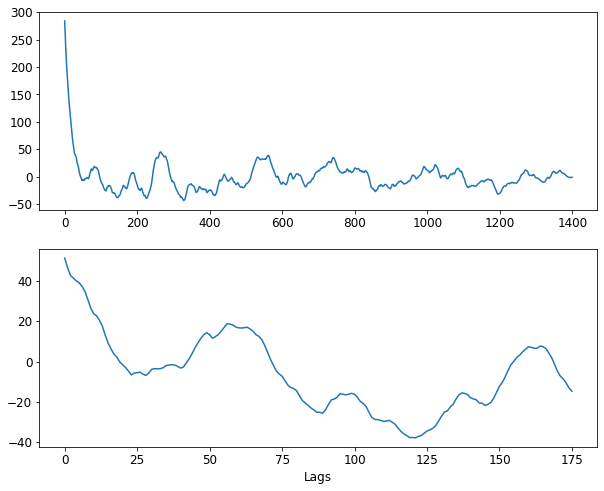

			Plot for target: WindSpeed


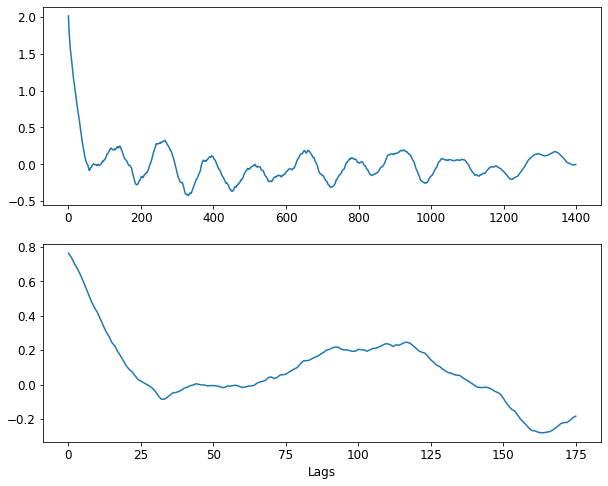

In [17]:
for column in target_columns:
    print("\t\t\tPlot for target:", column)
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(stattools.acovf(target_df[column], fft=False))
    ax2.plot(stattools.acovf(target_df[column], nlag=200, fft=False)[25:])
    plt.xlabel(f'Lags' )
    # plt.title(f'High autocovariance')
    plt.show()

In [18]:
target_columns

['WindDirection', 'WindSpeed']

			Plots for target: WindDirection


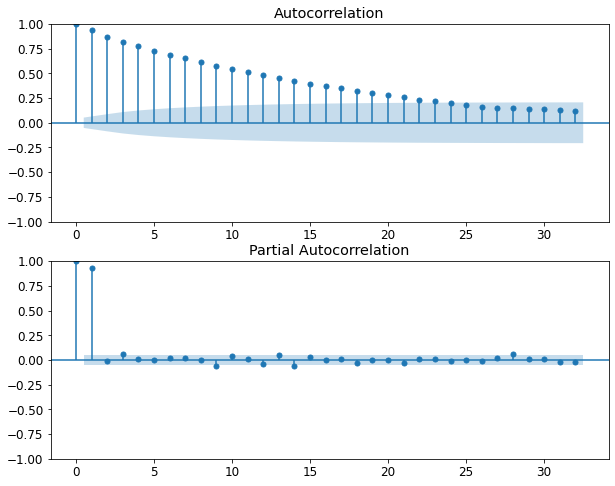

			Plots for target: WindSpeed


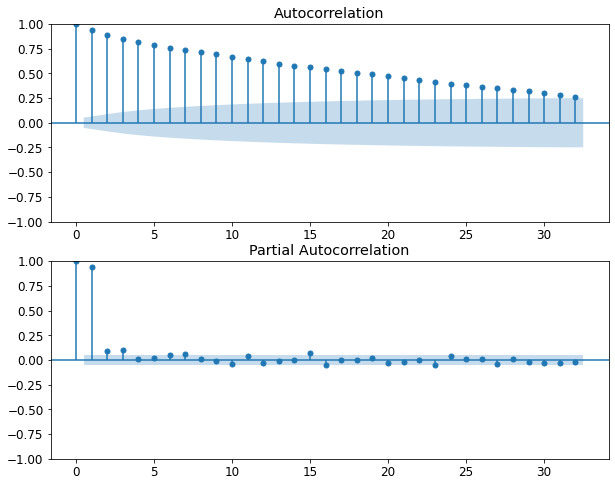

In [19]:
for column in target_columns:
  print("\t\t\tPlots for target:", column)
  fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
  plot_acf(target_df[column], ax = ax1)
  plot_pacf(target_df[column], ax = ax2)
  plt.show()

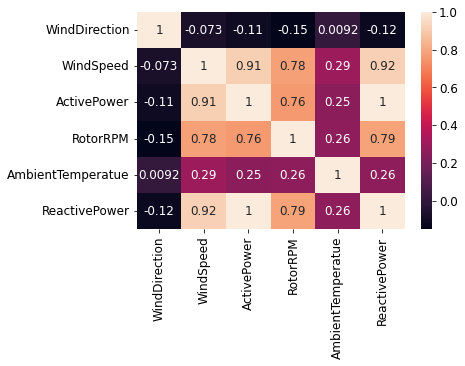

In [20]:
corrMatrix = target_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

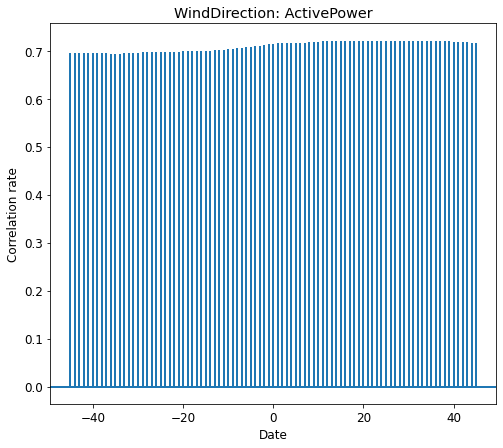

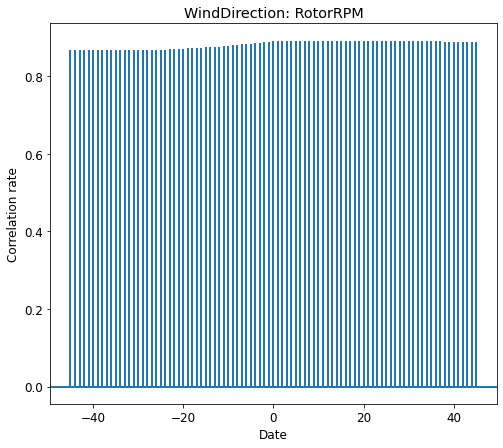

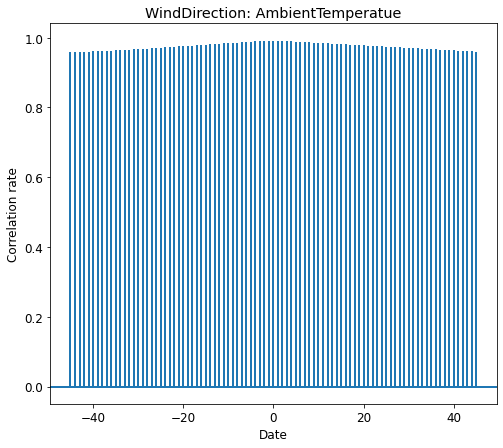

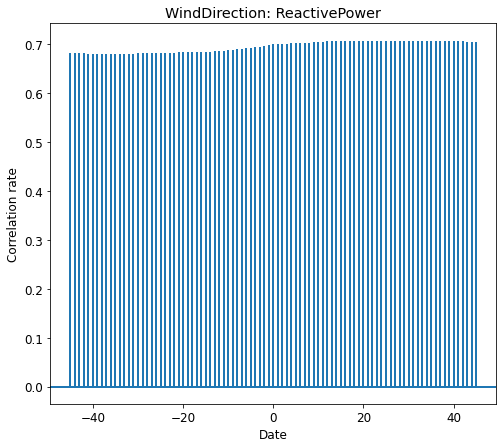

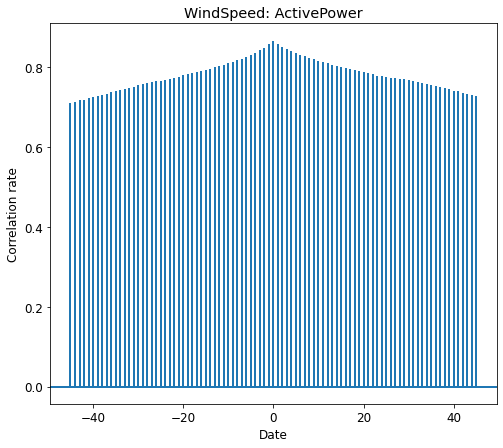

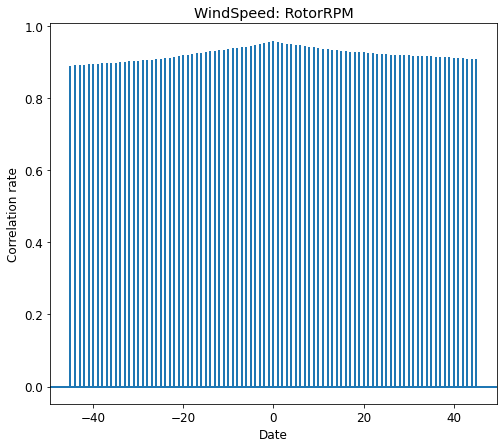

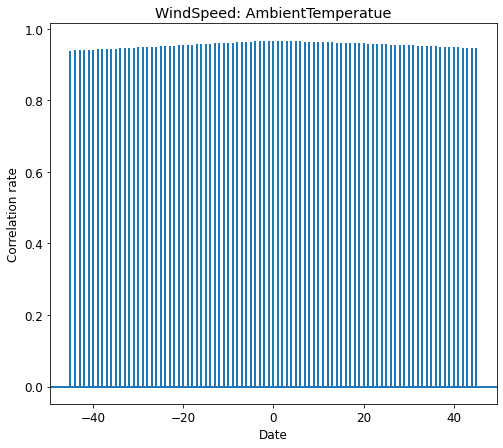

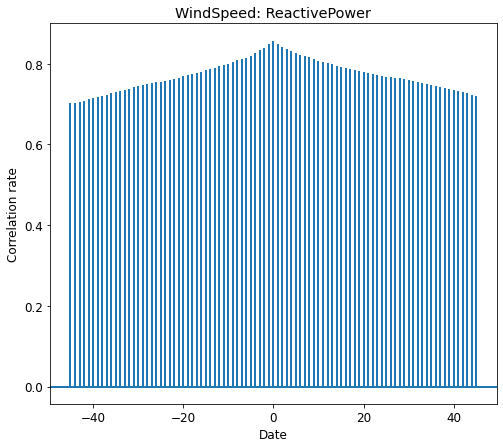

In [21]:
for target in target_columns:
    for predictor in predict_columns:  
        fig, axs = plt.subplots(1,figsize=(8, 7))
        axs.xcorr(target_df[target].astype(float), target_df[predictor].astype(float), usevlines=True, maxlags=45, normed=True, lw=2)
        axs.set_title(f"{target}: {predictor}")
        axs.set_ylabel('Correlation rate')
        axs.set_xlabel('Date')

# Step 4 - Filter high frequencies (noise) with chosen 2 filters for target variables.

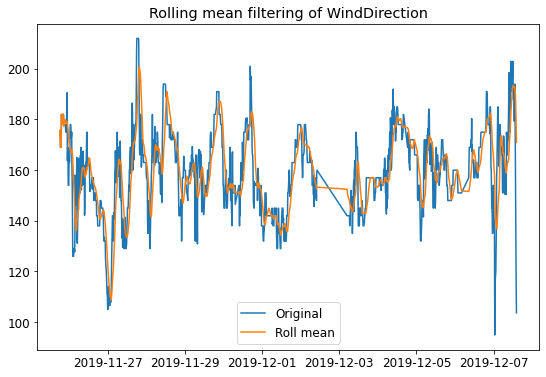

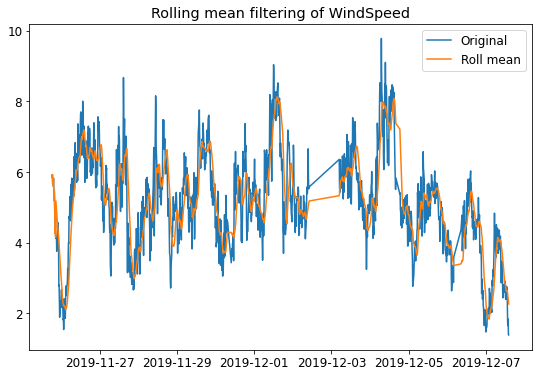

In [24]:
# Rolling mean filtering
i=1
filtered_df = target_df

for item in target_columns:
    variable_roll = target_df[item].head(14).values
    variable_roll = np.append(variable_roll, target_df[item].rolling(window=15).mean().iloc[15-1:].values)
    i+=1
    filtered_df[f'mean_{item}'] = variable_roll
    fig, axs = plt.subplots(figsize=(9, 6),squeeze=False)
    plt.plot(list(target_df['Date']), list(target_df[item]), label = f'Original')
    plt.plot(list(target_df['Date']), list(variable_roll), label = f'Roll mean')
    plt.title(f'Rolling mean filtering of {item}')
    plt.legend(loc='best')


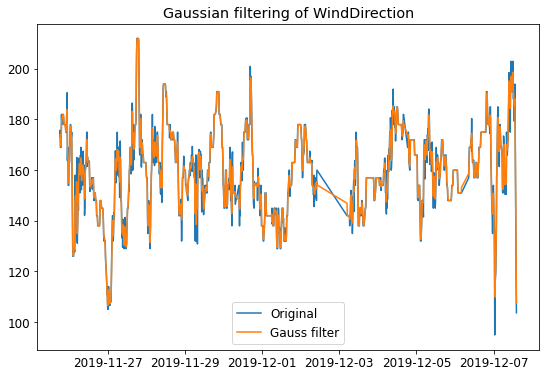

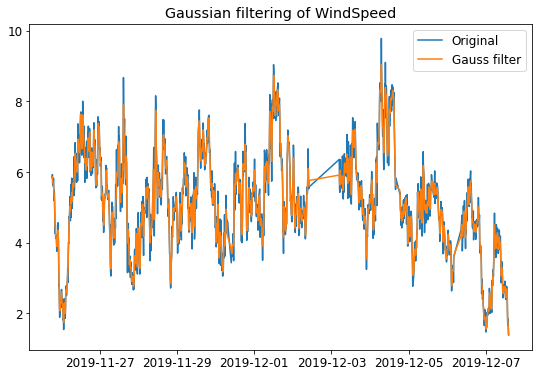

In [25]:
# gaussian filter
for item in target_columns:
    fig, axs = plt.subplots(figsize=(9, 6),squeeze=False)
    gauss_column = gaussian_filter1d(np.array(target_df[item], np.float), 0.90)
    filtered_df[f'gauss_{item}'] = gauss_column
    plt.plot(list(target_df['Date']), list(list(target_df[item])), label = f'Original')
    plt.plot(list(target_df['Date']), list(gauss_column), label = f'Gauss filter')
    plt.title(f'Gaussian filtering of {item}')
    plt.legend(loc='best')
    
# print(filtered_df)

# Step 5 - Estimate spectral density function with and without filtering.

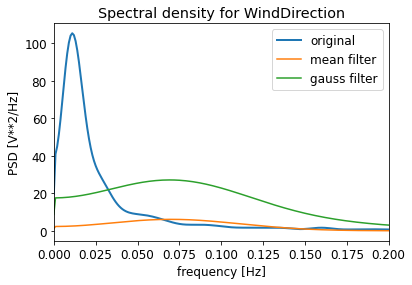

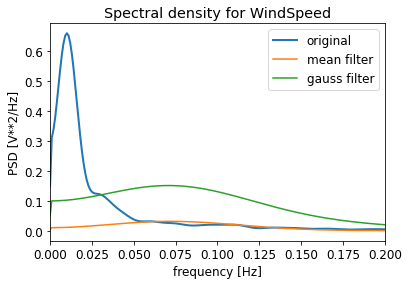

In [26]:
window_size = 15
blackman = signal.blackman(M=window_size)


#item_columns = target_columns + [f'mean_{item}' for item in target_columns] + [f'gauss_{item}' for item in target_columns]

for item in target_columns:
    f, Pxx_den = signal.welch(target_df[item], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(target_df[f'mean_{item}'], fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window2, Pxx_den_window2 = signal.welch(target_df[f'gauss_{item}'], fs=1, window = blackman, nfft = 1000, scaling='spectrum')

    #f_window_bart, Pxx_den_window_bart = signal.welch(target_df[item], fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

    Pxx_den = [item.real for item in Pxx_den]
    f =  [item.real for item in f]
    f_window = [item.real for item in f_window]
    Pxx_den_window = [item.real for item in Pxx_den_window]
    f_window2 = [item.real for item in f_window2]
    Pxx_den_window2 = [item.real for item in Pxx_den_window2]
    #f_window_bart = [item.real for item in f_window_bart]
    #Pxx_den_window_bart = [item.real for item in Pxx_den_window_bart]

    plt.plot(f, Pxx_den, linewidth=2, label = 'original')
    plt.plot(f_window, Pxx_den_window, label = 'mean filter')
    plt.plot(f_window2, Pxx_den_window2, label = 'gauss filter')

    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(loc='best')
    plt.title(f'Spectral density for {item}')
    plt.xlim((0,0.2))
    plt.show()

# Step 6 - Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.

In [ ]:
target_columns

Seasonality about 80-115 intervals - auto_arima can't calculate models - RAM error (it consumes too much memory)

In [179]:
auto_arima(target_df[column], seasonal=True,
                      test='adf',error_action='ignore',
                      suppress_warnings=True, m=12, start_p=1, max_p=12,
                      stepwise=True, trace=True,start_q=1, max_q=12,)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.94 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4428.532, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1629.333, Time=2.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2934.014, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8722.749, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1630.019, Time=0.25 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1631.064, Time=7.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1629.415, Time=1.00 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=3887.304, Time=0.98 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1623.594, Time=3.63 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1623.701, Time=0.46 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1625.606, Time=9.15 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [162]:
ls_auto_arima = []
for column in target_columns:
  ls_auto_arima.append(auto_arima(target_df[column], seasonal=True,
                      start_p=0, start_q=0, max_order=5, test='adf',error_action='ignore',
                      suppress_warnings=True, m=12,
                      stepwise=True, trace=True))
  
                            
  

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=11522.035, Time=2.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11885.590, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8923.674, Time=2.00 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10395.212, Time=1.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=18191.660, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8924.622, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8925.389, Time=6.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8923.768, Time=1.27 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=7.51 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=11507.807, Time=2.38 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=8925.269, Time=3.05 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=8925.218, Time=3.75 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=11165.948, Time=3.44 sec
 ARIMA(2,0,1)(1,0,0)[12

In [27]:
ls_auto_arima = []
for column in target_columns:
  ls_auto_arima.append(auto_arima(target_df[column], seasonal=True,
                      start_p=0, start_q=0, max_order=5, test='adf',error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, trace=True))
  

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11885.590, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8924.622, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10568.306, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18191.660, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8926.338, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8926.305, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8926.988, Time=1.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.663 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4957.734, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1996.984, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3668.758, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8672.283, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1984.

In [28]:
for info in ls_auto_arima:
  print(info.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1400
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4459.311
Date:                Sat, 10 Dec 2022   AIC                           8924.622
Time:                        11:06:15   BIC                           8940.355
Sample:                             0   HQIC                          8930.503
                               - 1400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.2977      1.412      6.584      0.000       6.530      12.065
ar.L1          0.9415      0.009    105.718      0.000       0.924       0.959
sigma2        34.1632      0.675     50.635      0.0

In [30]:
target_columns_flt = ['mean_WindDirection', 'mean_WindSpeed', 'gauss_WindDirection', 'gauss_WindSpeed']

In [31]:
ls_auto_arima = []
for column in target_columns_flt:
  ls_auto_arima.append(auto_arima(filtered_df[column], seasonal=True,
                      start_p=0, start_q=0, max_order=5, test='adf',error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, trace=True))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11493.858, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18190.055, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3743.206, Time=1.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3067.389, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3124.414, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3067.985, Time=1.53 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3067.498, Time=1.53 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3541.732, Time=2.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3077.241, Time=1.60 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3055.962, Time=1.90 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2967.620, Time=2.04 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3011.933, Time=1.73 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC

In [32]:
coefficients = [(4,0,4), (3,0,0), (1,0,3), (5,0,3)]

In [33]:
for info in ls_auto_arima:
  print(info)

 ARIMA(4,0,4)(0,0,0)[0] intercept
 ARIMA(3,0,0)(0,0,0)[0] intercept
 ARIMA(1,0,3)(0,0,0)[0] intercept
 ARIMA(5,0,3)(0,0,0)[0] intercept


In [ ]:
filtered_df

In [ ]:
target_columns

In [35]:
from scipy.stats import shapiro

Residuals mean: 0    0.200491
dtype: float64 
Residuals std: 0    7.391484
dtype: float64
ShapiroResult(statistic=0.6444714069366455, pvalue=0.0)


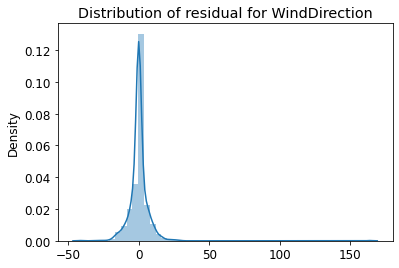

(0.0, 30.0)

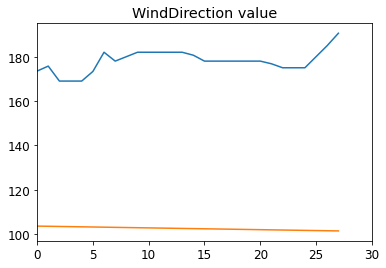

In [190]:
test, train = train_test_split(target_df[target_columns[0]], test_size=0.98, shuffle = False, random_state=42)
train = np.asarray(train, dtype=np.float)
test = np.asarray(test, dtype=np.float)

model = SARIMAX(train, order = (1,0,0),seasonal_order = (0,0,0,0))
# model = ARIMA(train, order=(1,0,0))
fitted = model.fit()

residuals = pd.DataFrame(fitted.resid)
sns.distplot(residuals, kde=True, norm_hist=True)
plt.title(f'Distribution of residual for {target_columns[0]}')
print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
plt.show()

forecast_test = fitted.forecast(len(test))
fc = forecast_test

d = {'target':  pd.Series(test), 'pred': fc}
df = pd.DataFrame(d)

# df.plot()
plt.plot(test)
plt.plot(fc)
plt.title(f'{target_columns[0]} value')
plt.xlim(0,30)

Residuals mean: 0    0.017962
dtype: float64 
Residuals std: 0    0.43559
dtype: float64
ShapiroResult(statistic=0.9714770317077637, pvalue=7.938447309413282e-16)


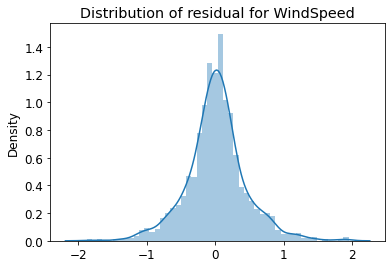

(0.0, 30.0)

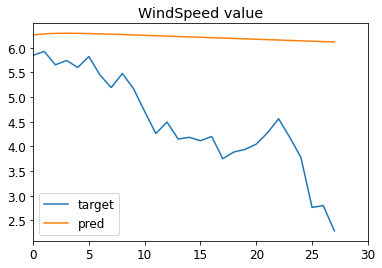

In [185]:
test, train = train_test_split(target_df[target_columns[1]], test_size=0.98, shuffle = False, random_state=42)
train = np.asarray(train, dtype=np.float)
test = np.asarray(test, dtype=np.float)

# model = ARIMA(train, order=(1,1,3))
model = SARIMAX(train, order = (3,0,2),seasonal_order = (0,0,0,0))
fitted = model.fit()

residuals = pd.DataFrame(fitted.resid)
sns.distplot(residuals, kde=True, norm_hist=True)
plt.title(f'Distribution of residual for {target_columns[1]}')
print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
plt.show()

forecast_test = fitted.forecast(len(test))
fc = forecast_test #pd.Series([None]*len(train) + list(forecast_test))

d = {'target':  pd.Series(test), 'pred': fc}
df = pd.DataFrame(d)

df.plot()
plt.title(f'{target_columns[1]} value')
plt.xlim(0,30)

Residuals mean: 0    0.128867
dtype: float64 
Residuals std: 0    4.851007
dtype: float64
ShapiroResult(statistic=0.05274909734725952, pvalue=0.0)


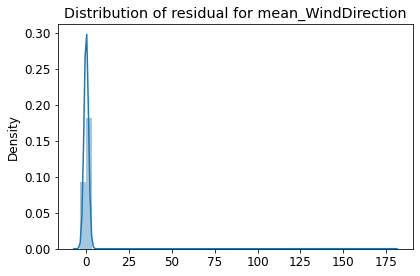

Residuals mean: 0    0.003774
dtype: float64 
Residuals std: 0    0.107963
dtype: float64
ShapiroResult(statistic=0.24571067094802856, pvalue=0.0)


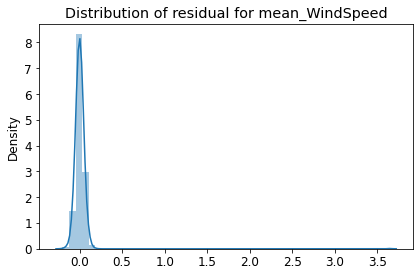

Residuals mean: 0    0.147607
dtype: float64 
Residuals std: 0    4.938811
dtype: float64
ShapiroResult(statistic=0.17245787382125854, pvalue=0.0)


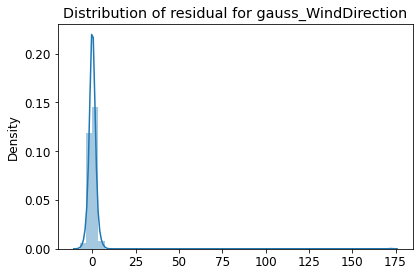

Residuals mean: 0    0.00699
dtype: float64 
Residuals std: 0    0.14712
dtype: float64
ShapiroResult(statistic=0.9114965200424194, pvalue=1.5496776704463205e-27)


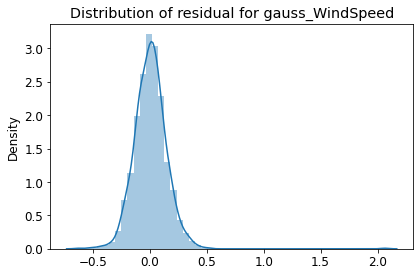

In [191]:
fitted_sr = []
for i in range(len(target_columns_flt)):
  test, train = train_test_split(filtered_df[target_columns_flt[i]], test_size=0.98, shuffle = False, random_state=42)
  train = np.asarray(train, dtype=np.float)
  test = np.asarray(test, dtype=np.float)




  model = SARIMAX(train, order = coefficients[i],seasonal_order = (0,0,0,0))
  fitted = model.fit(disp = 0)

  # model = ARIMA(train, order=(coefficients[i]))
  # fitted = model.fit()
  fitted_sr.append(fitted)

  residuals = pd.DataFrame(fitted.resid)
  sns.distplot(residuals, kde=True, norm_hist=True)
  plt.title(f'Distribution of residual for {target_columns_flt[i]}')
  print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
  plt.tight_layout()
  plt.show()

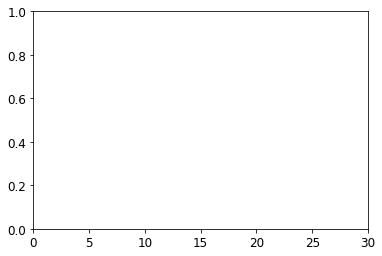

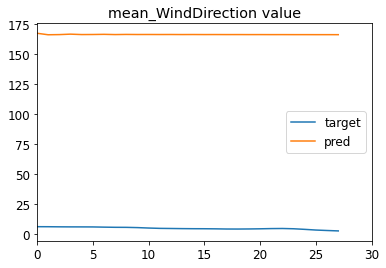

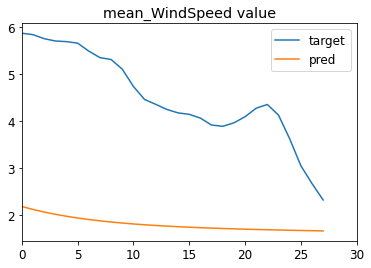

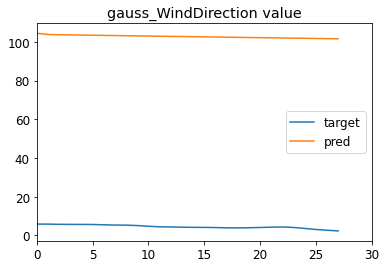

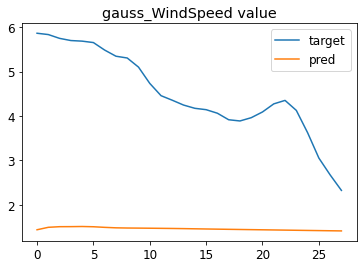

In [189]:
i = 0
for item in fitted_sr:
  forecast_test = item.forecast(len(test))


  # output = model_fit.forecast()

  # yhat = output[0]
  # predictions.append(float(yhat))

  # obs = test[t]
  # history.append(obs)

  # print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))


  d = {'target':  pd.Series(test), 'pred': forecast_test}
  df = pd.DataFrame(d)

  
  plt.xlim(0,30)
  
  df.plot()
  plt.title(f'{target_columns_flt[i]} value')
  i += 1
  

# Step 7 - Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model.

In [126]:
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)

    return input_data

def ts(target, predictor1, predictor2, predictor3, predictor4, forecast_length):
    ts_1 = wrap_into_input(forecast_length = forecast_length,
                           feature_time_series = np.array(target),
                           target_time_series = np.array(target))

    ts_2 = wrap_into_input(forecast_length = forecast_length,
                           feature_time_series = np.array(predictor1),
                           target_time_series = np.array(target))

    ts_3 = wrap_into_input(forecast_length = forecast_length,
                           feature_time_series = np.array(predictor2),
                           target_time_series = np.array(target))

    ts_4 = wrap_into_input(forecast_length = forecast_length,
                           feature_time_series = np.array(predictor3),
                           target_time_series = np.array(target))

    ts_5 = wrap_into_input(forecast_length = forecast_length,
                           feature_time_series = np.array(predictor4),
                           target_time_series = np.array(target))

    dataset = MultiModalData({
        f'data_source_ts/{target}': ts_1,
        f'data_source_ts/{predictor1}': ts_2,
        f'data_source_ts/{predictor2}': ts_3,
        f'data_source_ts/{predictor3}': ts_4,
        f'data_source_ts/{predictor4}': ts_5
    })

    return ts_1, ts_2, ts_3, ts_4, ts_5, dataset

def create_multisource_pipeline(target, predictor1, predictor2, predictor3, predictor4):
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode(f'data_source_ts/{target}')
    node_source_2 = PrimaryNode(f'data_source_ts/{predictor1}')
    node_source_3 = PrimaryNode(f'data_source_ts/{predictor2}')
    node_source_4 = PrimaryNode(f'data_source_ts/{predictor3}')
    node_source_5 = PrimaryNode(f'data_source_ts/{predictor4}')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
    node_lagged_3 = SecondaryNode('lagged', nodes_from=[node_source_3])
    node_lagged_4 = SecondaryNode('lagged', nodes_from=[node_source_4])
    node_lagged_5 = SecondaryNode('lagged', nodes_from=[node_source_5])

    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_lasso_2 = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    node_lasso_3 = SecondaryNode('lasso', nodes_from=[node_lagged_3])
    node_lasso_4 = SecondaryNode('lasso', nodes_from=[node_lagged_4])
    node_lasso_5 = SecondaryNode('lasso', nodes_from=[node_lagged_5])

    # node_ridge = SecondaryNode('ridge', nodes_from=[node_source_1])
    # node_lasso_2 = SecondaryNode('lasso', nodes_from=[node_source_2])
    # node_lasso_3 = SecondaryNode('lasso', nodes_from=[node_source_3])
    # node_lasso_4 = SecondaryNode('lasso', nodes_from=[node_source_4])
    # node_lasso_5 = SecondaryNode('lasso', nodes_from=[node_source_5])

    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_lasso_2, node_lasso_3, node_lasso_4, node_lasso_5])
    pipeline = Pipeline(node_final)
    return pipeline

In [ ]:
# target_columns = ['WindDirection', 'WindSpeed']
# predict_columns = ['ActivePower', 'RotorRPM', 'AmbientTemperatue', 'ReactivePower']

2022-12-10 12:15:06,278 - OperationTypesRepository - Operation lagged not found in the repository


2022-12-10 12:15:06,283 - OperationTypesRepository - Operation data_source_ts not found in the repository


2022-12-10 12:15:06,287 - OperationTypesRepository - Operation lagged not found in the repository


2022-12-10 12:15:06,291 - OperationTypesRepository - Operation data_source_ts not found in the repository


2022-12-10 12:15:06,294 - OperationTypesRepository - Operation lagged not found in the repository


2022-12-10 12:15:06,297 - OperationTypesRepository - Operation data_source_ts not found in the repository


2022-12-10 12:15:06,299 - OperationTypesRepository - Operation lagged not found in the repository


2022-12-10 12:15:06,302 - OperationTypesRepository - Operation data_source_ts not found in the repository


2022-12-10 12:15:06,305 - OperationTypesRepository - Operation lagged not found in the repository


2022-12-10 12:15:06,307 - OperationTypesRepository - Operation data_source_ts not found in the repository


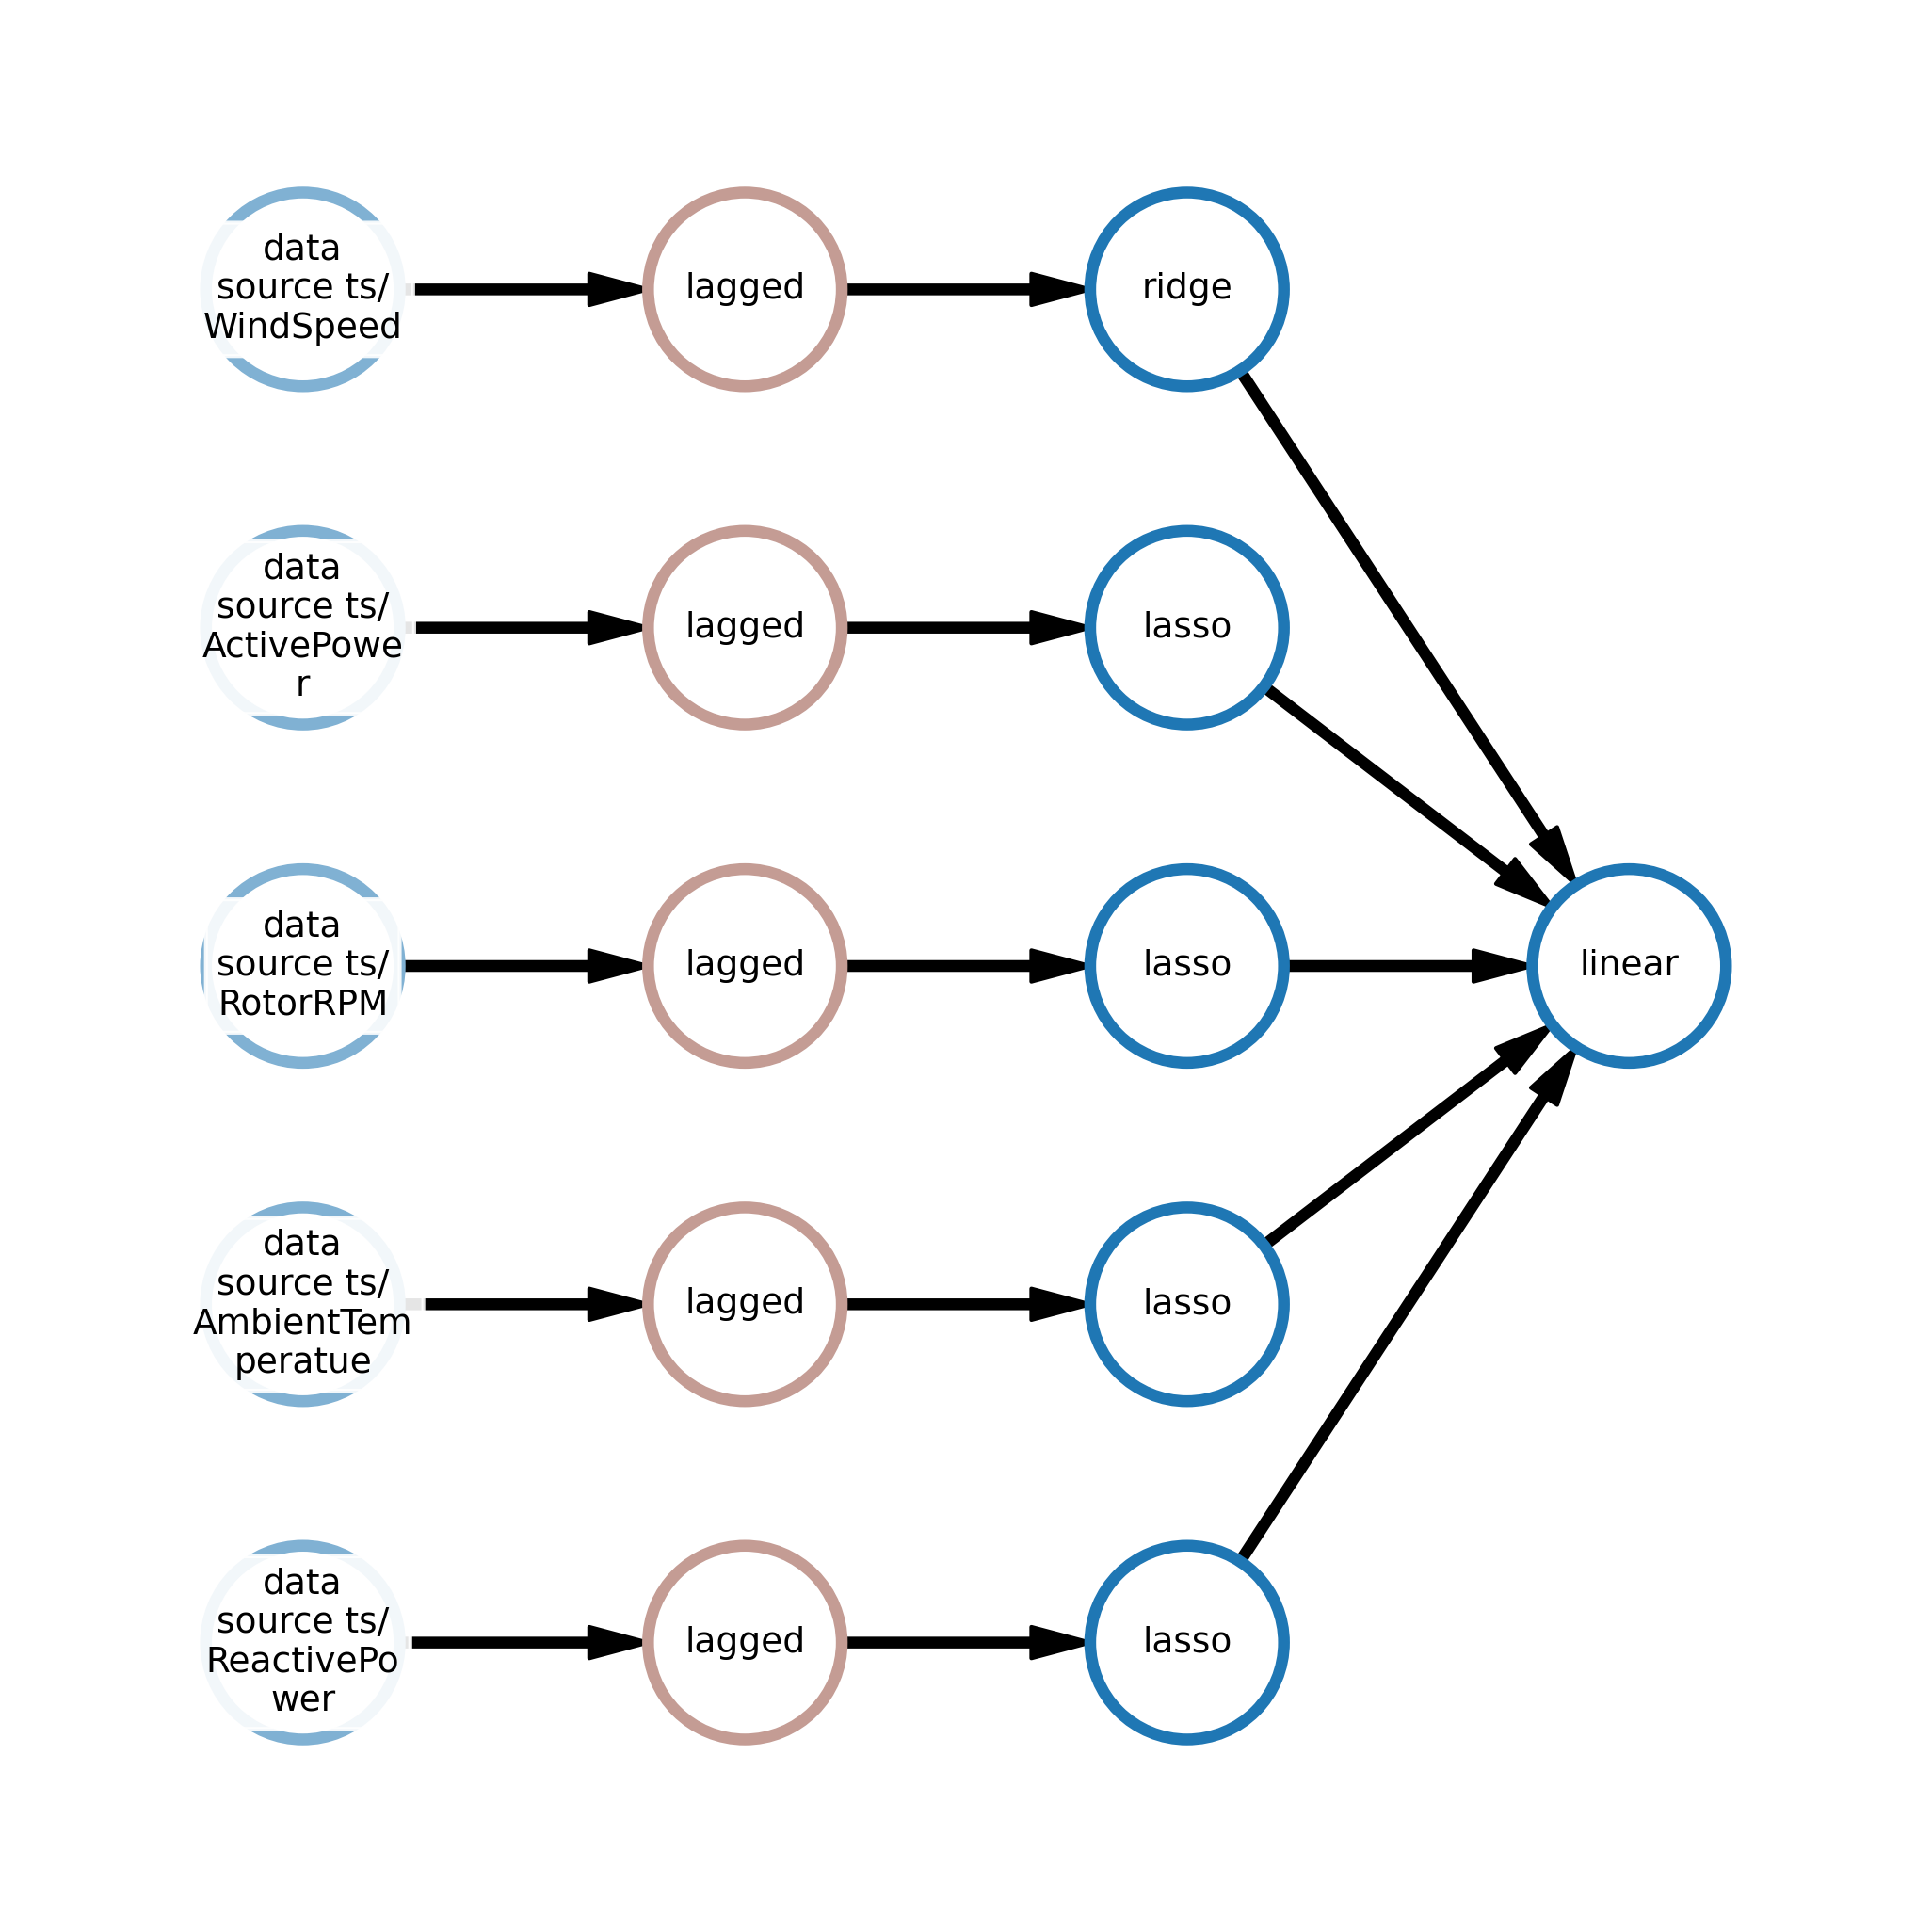

In [144]:
forecast_length = 100

target = target_df['WindSpeed']
predictor1 = target_df['ActivePower']
predictor2 = target_df['RotorRPM']
predictor3 = target_df['AmbientTemperatue']
predictor4 = target_df['ReactivePower']

ts_1, ts_2, ts_3, ts_4, ts_5, dataset = ts(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4, forecast_length = forecast_length)

train, test = train_test_data_setup(dataset)

pipeline = create_multisource_pipeline(target = 'WindSpeed', predictor1 = 'ActivePower', predictor2 = 'RotorRPM', predictor3 = 'AmbientTemperatue', predictor4 = 'ReactivePower',)
pipeline.show()

In [145]:
pipeline = create_multisource_pipeline(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4)

pipeline.fit(train)
forecast = pipeline.predict(test)

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

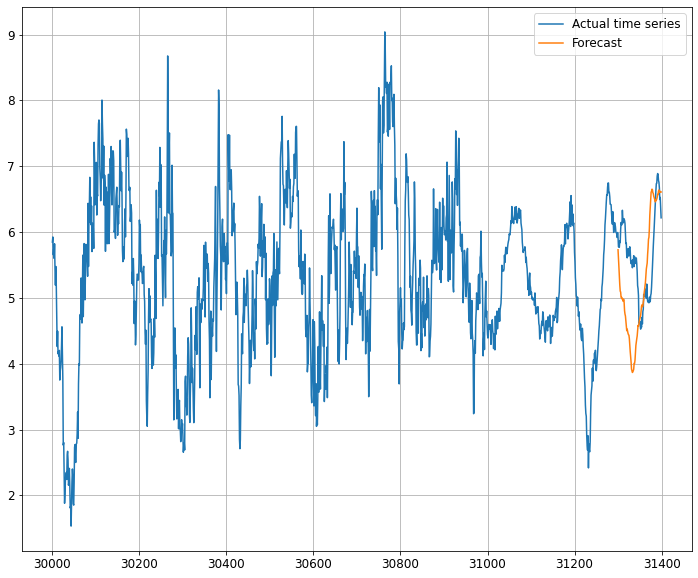

MAE metric value: 0.80
MSE: 0.9519378398712093


In [146]:
nans = np.array([np.nan]*len(target_df['Date']))
forecast_df = target_df[['Date']+target_columns]
forecast_df['ForWindSpeed'] = nans#forecast_df['WindSpeed']

pred_fore1 = forecast.predict
part_col = nans#np.asarray(target_df['WindSpeed'], dtype=np.float)
part_col[len(target_df['Date'])-forecast_length:] = pred_fore1.reshape(-1)
forecast_df['ForWindSpeed'] = part_col

plt.figure(figsize=(12,10))
plt.plot(forecast_df.WindSpeed, label='Actual time series')
plt.plot(forecast_df.ForWindSpeed, label='Forecast')
plt.legend()
plt.grid()
plt.show()

target_value = np.asarray(target_df['WindSpeed'], dtype=np.float)
metric = mean_absolute_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict))
print(f'MAE metric value: {metric:.2f}')
print('MSE:', mean_squared_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict)))


Residuals mean: 0.3658496427536011 
Residuals std: 0.9044843164855163
ShapiroResult(statistic=0.9386483430862427, pvalue=0.0001596113870618865)


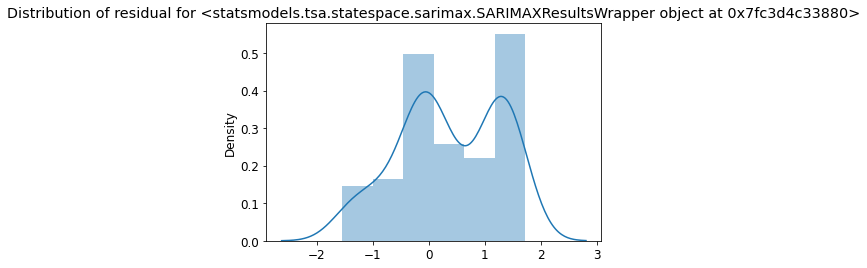

In [147]:
residuals = target_value[len(target_df['Date'])-forecast_length:] - np.ravel(forecast.predict)
sns.distplot(residuals, kde=True, norm_hist=True)
plt.title(f'Distribution of residual for {item}')
print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
plt.show()

In [138]:
forecast_length = 100

target = target_df['WindDirection']
predictor1 = target_df['ActivePower']
predictor2 = target_df['RotorRPM']
predictor3 = target_df['AmbientTemperatue']
predictor4 = target_df['ReactivePower']

ts_1, ts_2, ts_3, ts_4, ts_5, dataset = ts(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4, forecast_length = forecast_length)

train, test = train_test_data_setup(dataset)

pipeline = create_multisource_pipeline(target = 'WindDirection', predictor1 = 'ActivePower', predictor2 = 'RotorRPM', predictor3 = 'AmbientTemperatue', predictor4 = 'ReactivePower',)
# pipeline.show()
pipeline = create_multisource_pipeline(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4)

pipeline.fit(train)
forecast = pipeline.predict(test)

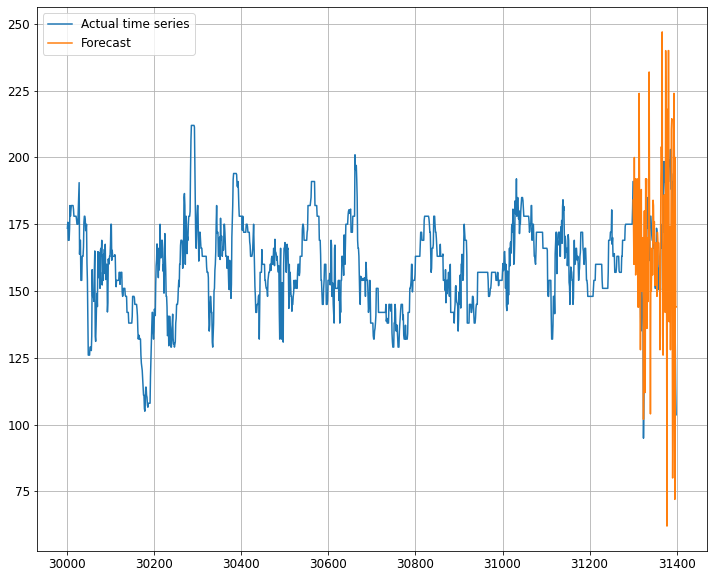

MAE metric value: 29.34
MSE: 1416.802649713274


In [140]:
nans = np.array([np.nan]*len(target_df['Date']))
forecast_df = target_df[['Date']+target_columns]
forecast_df['ForWindDirect'] = nans

pred_fore = forecast.predict
part_col = nans
part_col[len(target_df['Date'])-forecast_length:] = pred_fore.reshape(-1)
forecast_df['ForWindDirect'] = part_col

plt.figure(figsize=(12,10))
plt.plot(forecast_df.WindDirection, label='Actual time series')
plt.plot(forecast_df.ForWindDirect, label='Forecast')
plt.legend()
plt.grid()
plt.show()

target_value = np.asarray(target_df['WindDirection'], dtype=np.float)
metric = mean_absolute_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict))
print(f'MAE metric value: {metric:.2f}')
print('MSE:', mean_squared_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict)))

Residuals mean: 2.502852813852815 
Residuals std: 37.55713484153794
ShapiroResult(statistic=0.9782854318618774, pvalue=0.09764482825994492)


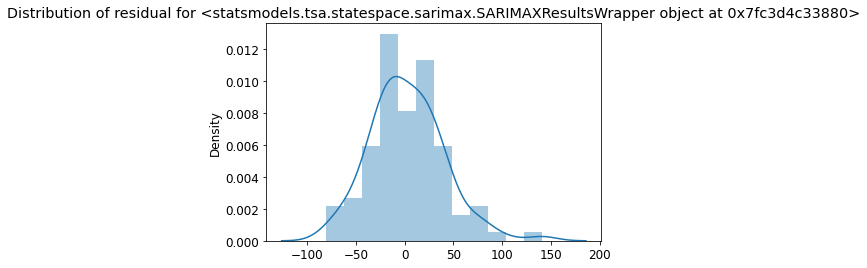

In [142]:
residuals = target_value[len(target_df['Date'])-forecast_length:] - np.ravel(forecast.predict)
sns.distplot(residuals, kde=True, norm_hist=True)
plt.title(f'Distribution of residual for {item}')
print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
plt.show()

In [143]:
# filtered_df
# filtered_df.mean_WindSpeed

,Date,WindDirection,WindSpeed,ActivePower,RotorRPM,AmbientTemperatue,ReactivePower,mean_WindDirection,mean_WindSpeed,gauss_WindDirection,gauss_WindSpeed
30000,2019-11-25 18:20:00+00:00,173.5,5.848312,484.811382,10.401707,23.135894,99.035418,173.5,5.848312,173.937919,5.862186
30001,2019-11-25 18:30:00+00:00,175.75,5.926594,473.886145,10.434384,23.044191,97.104932,175.75,5.926594,173.248563,5.832516
30002,2019-11-25 18:40:00+00:00,169.0,5.654822,410.817685,9.859029,22.896918,83.383613,169.0,5.654822,170.798398,5.746862
30003,2019-11-25 18:50:00+00:00,169.0,5.743376,425.636621,10.05716,22.825172,86.624567,169.0,5.743376,169.446212,5.697815
30004,2019-11-25 19:00:00+00:00,169.0,5.601631,403.702268,9.886101,22.820358,82.993174,169.0,5.601631,170.551296,5.684361
...,...,...,...,...,...,...,...,...,...,...,...
31395,2019-12-07 13:30:00+00:00,164.2,6.670898,-5.703843,0.0,22.659033,-13.59253,189.805556,2.550689,164.347317,1.881887
31396,2019-12-07 13:40:00+00:00,148.25,6.496094,-5.776515,0.0,22.689633,-13.317937,186.955556,2.473547,147.436605,1.727266
31397,2019-12-07 13:50:00+00:00,129.0,6.526367,-5.297811,0.0,22.614557,-12.133637,182.822222,2.422593,130.434652,1.660923
31398,2019-12-07 14:00:00+00:00,114.0,6.375977,-5.47912,0.0,22.690502,-11.476812,177.288889,2.342366,116.101226,1.502575


In [148]:
forecast_length = 100

target = filtered_df['mean_WindSpeed']
predictor1 = target_df['ActivePower']
predictor2 = target_df['RotorRPM']
predictor3 = target_df['AmbientTemperatue']
predictor4 = target_df['ReactivePower']

ts_1, ts_2, ts_3, ts_4, ts_5, dataset = ts(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4, forecast_length = forecast_length)

train, test = train_test_data_setup(dataset)

pipeline = create_multisource_pipeline(target = 'mean_WindSpeed', predictor1 = 'ActivePower', predictor2 = 'RotorRPM', predictor3 = 'AmbientTemperatue', predictor4 = 'ReactivePower',)
# pipeline.show()
pipeline = create_multisource_pipeline(target = target, predictor1 = predictor1, predictor2 = predictor2, predictor3 = predictor3, predictor4 = predictor4)

pipeline.fit(train)
forecast = pipeline.predict(test)

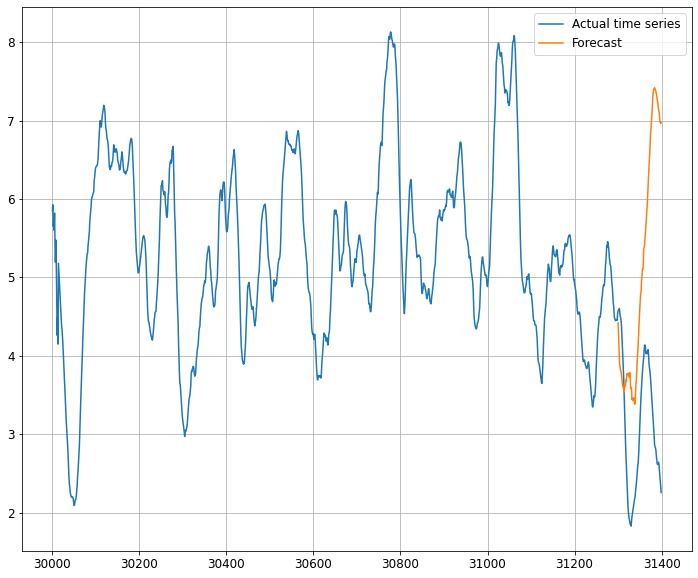

MAE metric value: 2.06
MSE: 6.267714898906906


In [149]:
nans = np.array([np.nan]*len(target_df['Date']))
forecast_df = filtered_df[['Date', 'mean_WindSpeed']+target_columns]
forecast_df['ForMeanWindSpeed'] = nans

pred_fore = forecast.predict
part_col = nans
part_col[len(target_df['Date'])-forecast_length:] = pred_fore.reshape(-1)
forecast_df['ForMeanWindSpeed'] = part_col

plt.figure(figsize=(12,10))
plt.plot(forecast_df.mean_WindSpeed, label='Actual time series')
plt.plot(forecast_df.ForMeanWindSpeed, label='Forecast')
plt.legend()
plt.grid()
plt.show()

target_value = np.asarray(filtered_df['mean_WindSpeed'], dtype=np.float)
metric = mean_absolute_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict))
print(f'MAE metric value: {metric:.2f}')
print('MSE:', mean_squared_error(target_value[len(target_df['Date'])-forecast_length:], np.ravel(forecast.predict)))

Residuals mean: -1.931583970729253 
Residuals std: 1.5927015611622655
ShapiroResult(statistic=0.8957126140594482, pvalue=8.936877975429525e-07)


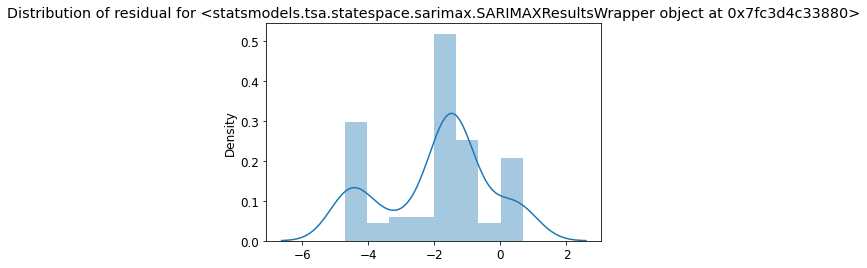

In [150]:
residuals = target_value[len(target_df['Date'])-forecast_length:] - np.ravel(forecast.predict)
sns.distplot(residuals, kde=True, norm_hist=True)
plt.title(f'Distribution of residual for {item}')
print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
plt.show()